In [1]:
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict
import random
import json
import networkx as nx
import pylab as plt
import matplotlib.transforms as mtransforms
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from scipy.stats import bootstrap

def bootstrapped(data,n_resamples = 50):
    data = (data,)
    bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,n_resamples=n_resamples,
                         random_state=1, method='percentile')
    return bootstrap_ci.confidence_interval

In [4]:
color_2 = {
    'paper':'#bf5700',
    'patent':'#58355e'
}

In [5]:
## mapping fields of papers 
M={'political science': 0,
 'geology': 1,
 'medicine': 2,
 'history': 3,
 'mathematics': 4,
 'physics': 5,
 'materials science': 6,
 'biology': 7,
 'business': 8,
 'chemistry': 9,
 'engineering': 10,
 'economics': 11,
 'art': 12,
 'philosophy': 13,
 'computer science': 14,
 'geography': 15,
 'psychology': 16,
 'sociology': 17,
 'environmental science': 18}
MP = {M[i]:i for i in M}
SE = [1,2,4,5,6,7,9,10,14,15,18]## science and engineering
SS = [0,8,11,16,17]## social sciences
AH = [3,12,13]## art and humanity

FM = {}
for f in SE:
    FM[f] = 'SE'
for f in SS:
    FM[f] = 'SS'
for f in AH:
    FM[f] = 'AH'

FN = {
    'SE':'Science and Engineering',
    'SS':'Social Sciences',
    'AH':'Art and Humanity',
}

## mapping fields of patents 
M_ = {
    'B':'Operation',
    'E':'Construction',
    'F':'Mechnical Engineering',
    'H':'Electricity',
    'Y':'Cross-section',
    'G':'Physics',
    'C':'Chemistry',
    'D':'Textiles',
    'A':'Human Necessities'}

## 1. read data

In [14]:
path = '/Users/linyiling/Dropbox/Carl/5 submit nature/raw_data/'

### 1.1 maps

#### 1.1.1 Papers

In [15]:
## dots
### city latitude and longitude
df_city_pa = pd.read_csv(path+'ScienceCityLatLong.csv')

## edges
### city dots that contain five or more onsite teams
citynodes = pd.read_csv(path+'ScienceDisruptionCityNodes.csv')
### city edges that contain five or more remote teams
city_path = {}
EC = {}
main_city = {}
with open(path+'ScienceDisruptionCityEdges.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        pair = tuple(line[0].split('&'))
        color = line[1]
        city_path[pair] = [list(map(float,line[3].split(','))),list(map(float,line[4].split(',')))]
        EC[pair] = color
        if int(line[2]) == 1:
            main_city[pair] = 1
DC = dict(zip(list(citynodes['City']),list(citynodes['Color'])))
CLla = dict(zip(list(df_city_pa['City']),list(df_city_pa['Lat'])))
CLln = dict(zip(list(df_city_pa['City']),list(df_city_pa['Lng'])))
CL_paper = {c:(CLln[c],CLla[c]) for c in CLla}

#### 1.1.2 patents

In [16]:
## dots
### city latitude and longitude
df_city_pt = pd.read_csv(path+'TechnologyCityLatLong.csv')
CLla_pt = dict(zip(list(df_city_pt['City']),list(df_city_pt['Lat'])))
CLln_pt = dict(zip(list(df_city_pt['City']),list(df_city_pt['Lng'])))
CL_patent = {c:(CLln_pt[c],CLla_pt[c]) for c in CLla_pt}
## edges
### city dots that contain five or more onsite teams
citynodes = pd.read_csv(path+'TechnologyDisruptionCityNodes.csv')
DC_pt = dict(zip(list(citynodes['City']),list(citynodes['Color'])))
### city edges that contain five or more remote teams
city_path_pt = {}
EC_pt = {}
main_city_pt = {}
with open(path+'TechnologyDisruptionCityEdges.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        pair = tuple(line[0].split('&'))
        color = line[1]
        city_path_pt[pair] = [list(map(float,line[3].split(','))),list(map(float,line[4].split(',')))]
        EC_pt[pair] = color
        if int(line[2]) == 1:
            main_city_pt[pair] = 1

### 1.2 Collaboration distance

#### 1.2.1 papers

In [17]:
p_y = {}
Dis_mean = {}
TS = {}
p_d = {}
p_f = {}
with open(path+'Paperid_Year_Discipline_Teamsize_Distance_Dscore.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        p = int(line[0])
        p_y[p] = int(line[1])
        Dis_mean[p] = float(line[4])
        TS[p] = int(line[3])
        if line[-1] != 'nan':
            p_d[p] = float(line[-1])
        if line[2] != '-1':
            p_f[p] = M[line[2]]

In [18]:
# len(Dis_mean) = 20134803, len(p_d) = 14485326

#### 1.2 patents

In [19]:
p_y3_ = {}
TS_ = {}
Dis_mean_ = {}
p_d_pt2 = {}
p_f_pt = {}
with open(path+'Patentid_Year_Field_Teamsize_Distance_Dscore.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        p = line[0]
        p_y3_[p] = int(line[1])
        TS_[p] = int(line[3])
        Dis_mean_[p] = float(line[4])
        if line[-1] != 'nan':
            p_d_pt2[p] = float(line[-1])
        if line[2]!='-1':
            p_f_pt[p] = line[2]

In [20]:
# len(Dis_mean_) = 4060564, len(p_d_pt2) = 3411366

### 1.3 Collaboration timezone difference

#### 1.3.1 papers

In [21]:
TZD = {}
with open(path+'Paperid_TimeZonedifference.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        p = int(line[0])
        if p in p_d:
            TZD[p] = float(line[1])

#### 1.3.2 patents

In [22]:
TZD_pt = {}
with open(path+'Patentid_Timezonedifference.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        p = line[0]
        if p in p_d_pt2:
            TZD_pt[p] = float(line[1])

### 1.4 paper team roles

In [23]:
## Author contribution
data = pd.read_csv(path+'Paperid_Remoteness_Authors_Teamroles.csv')
data_ = json.loads(data.to_json(orient = 'records'))
data_ = dict(zip(data['paperid'],data_))
PA = {}
for p in data_:
    PA[p] = {}
    PA[p]['Authors'] = list(map(int,data_[p]['authors'].split('&')))
    PA[p]['Remoteness'] = data_[p]['remoteness']
    PA[p]['Contributions'] = {}
    for w in ['conceived','wrote','performed','analyzed']:
        if data_[p][w]:
            PA[p]['Contributions'][w] = list(map(int,data_[p][w].split('&')))
        else:
            PA[p]['Contributions'][w] = []

In [24]:
## whether co-conceiving of the co-authors in terms of their citation impact differences
### To make onsite team and remote team compareable, we focus on team size from 2-8 (representing 74% of papers), 
### the result in Fig. 2b can also be reproduced for teams with full range of team size.
# onsite teams
GO_SC_R = defaultdict(list)
# remote teams
GR_SC_R = defaultdict(list)
# the number of papers with 2 - 8 authors
n = 0
with open(path+'Paperid_Year_TeamSize_AuthorCitationCumulative.txt','r') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        # paper ID
        p = int(line[0])
        # team size
        ts = int(line[2])
        if ts<=8: ## for team size from 2-8
            n += 1
            # authors and their cumulative citations
            as_ = line[3:]
            # author IDs
            a1 = list(map(int,np.array(as_)[list(range(0,len(as_),2))]))
            # citation counts
            a2 = list(map(int,np.array(as_)[list(range(1,len(as_),2))]))
            # combining author IDs and citation counts into a dictionary
            ac = dict(zip(a1,a2))

            # if everything is fine when parsing and the lengths match up
            if len(ac) == len(a1):
                # get the set of all authors who were behind the conception of the paper
                aus_ = set(PA[p]['Contributions'].get('conceived',[]))
                rs = []
                rs_ = []
                cs = []

                # for all pairs of authors on the paper
                for i,j in itertools.combinations(list(ac.keys()),2):
                    # check if both authors conceived of this paper
                    if i in aus_ and j in aus_:
                        if ac[i] > 0 or ac[j] > 0:## at least one members have citation data
                            # add the absolute difference of the log10 cumulative citation count for this pair of authors
                            rs.append(abs(np.log10(ac[i]+1)-np.log10(ac[j]+1)))
                            # record that the authors co-conceived
                            cs.append(1)        
                    else:
                        if ac[i] > 0 or ac[j] > 0:
                            rs.append(abs(np.log10(ac[i]+1)-np.log10(ac[j]+1)))
                            cs.append(0)
                            
                # record whether the paper was a "remote" paper or not
                if PA[p]['Remoteness']==0:
                    for i in range(len(rs)):
                        GO_SC_R[rs[i]].append(cs[i])
                else:
                    for i in range(len(rs)):
                        GR_SC_R[rs[i]].append(cs[i])

## Figure 1a-d

In [25]:
import geopandas

In [26]:
color_dict = {'Africa':'#070707', 'Antarctica':'#070707', 'Asia':'#070707', 
              'Europe':'#070707', 'North America':'#070707',
              'Oceania':'#070707', 'Seven seas (open ocean)':'#070707',
              'South America':'#070707'}

In [27]:
city_gdf_pa = geopandas.GeoDataFrame(
    df_city_pa, geometry=geopandas.points_from_xy(df_city_pa.Lng, df_city_pa.Lat))
city_gdf_pt = geopandas.GeoDataFrame(
    df_city_pt, geometry=geopandas.points_from_xy(df_city_pt.Lng, df_city_pt.Lat))

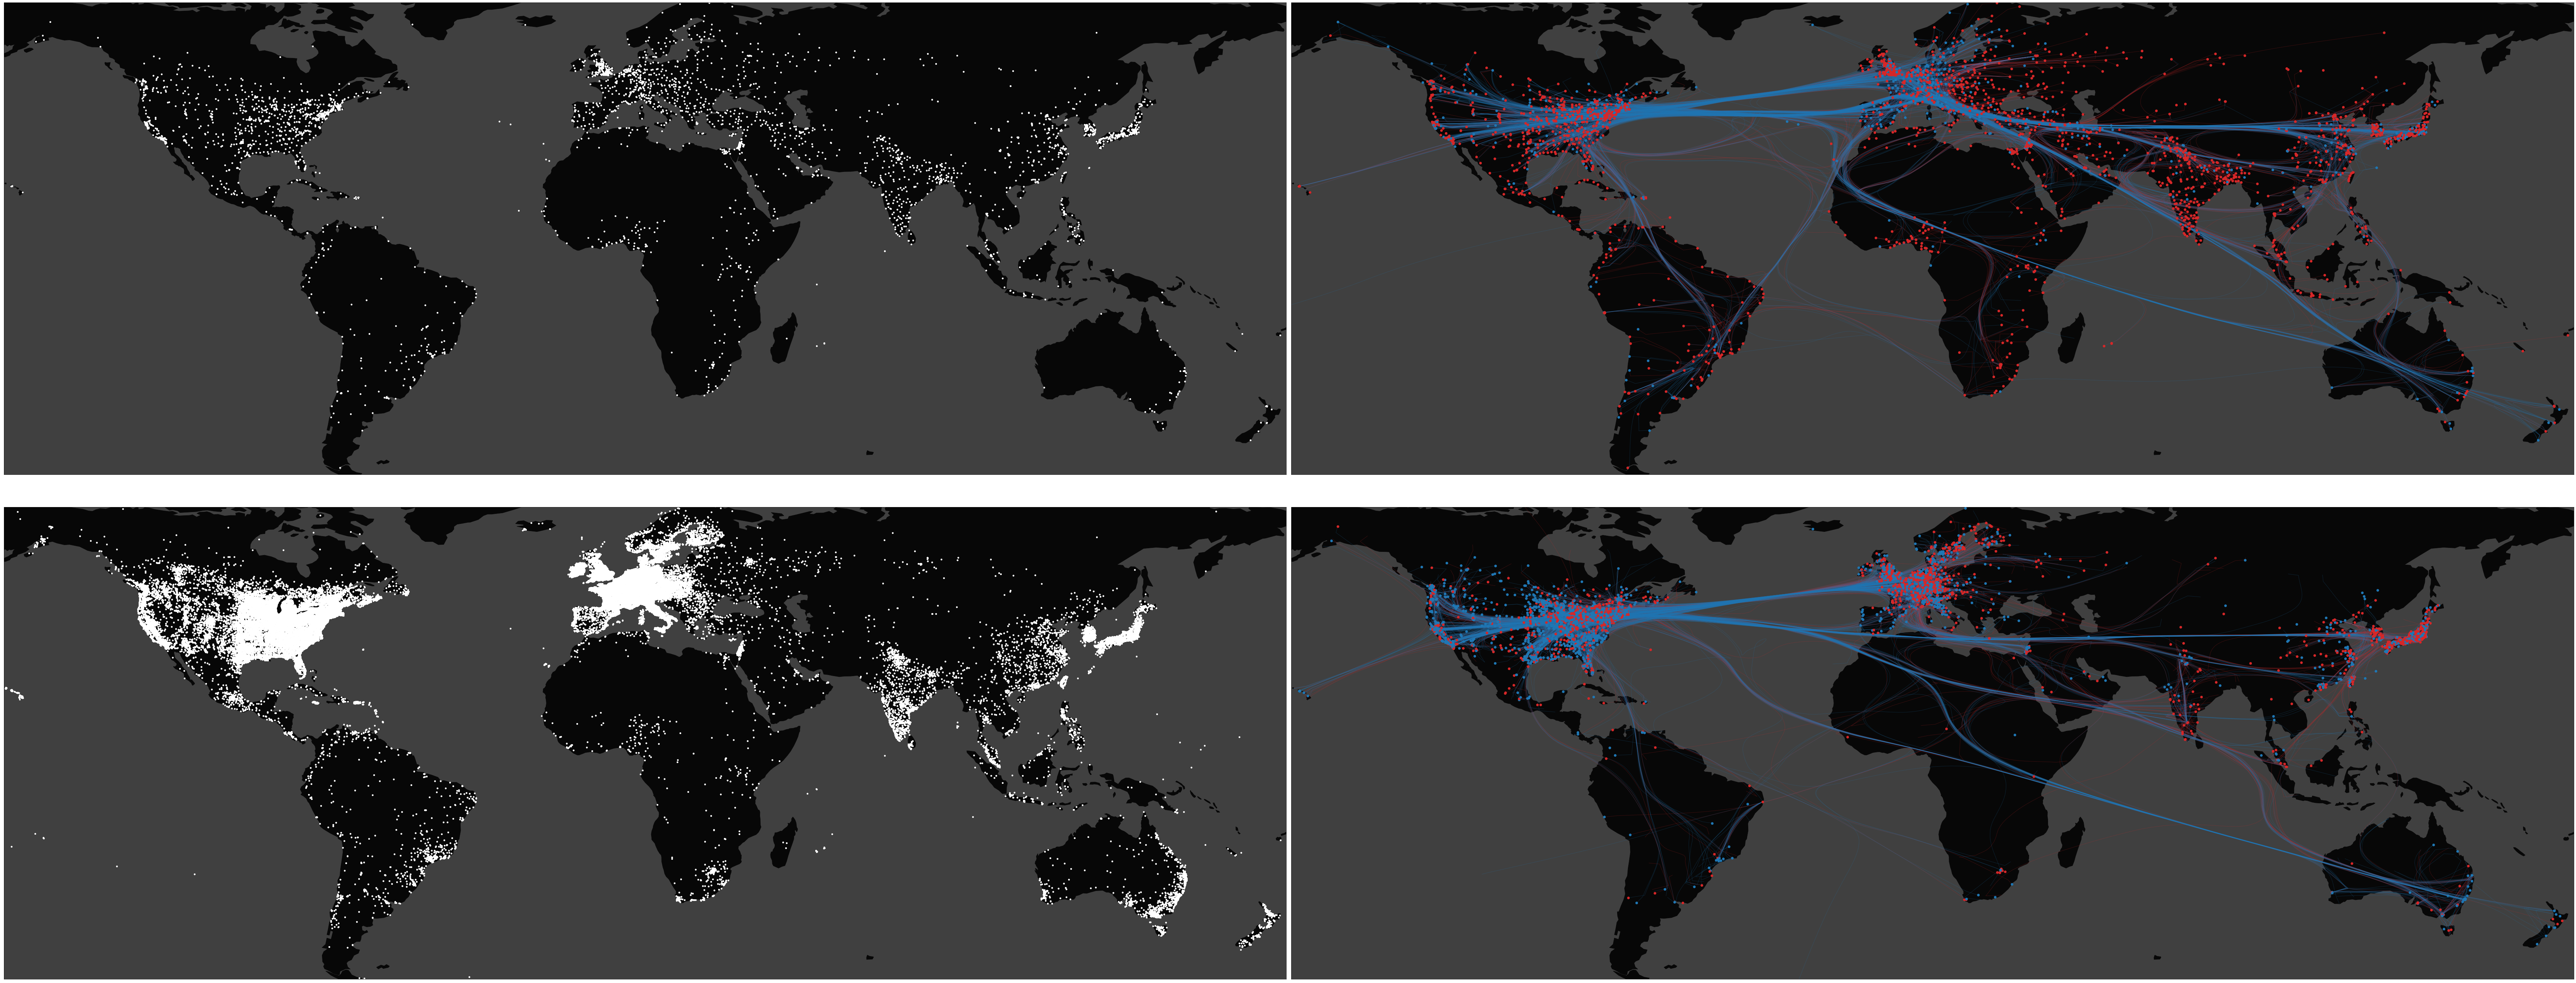

In [28]:
fig, ((ax,ax2),(ax1,ax3))=plt.subplots(2,2,figsize=[100, 40])

alp = 0.25
lw_ = 1
cs = {
    'red':'#d62728',
    'blue':'#1f77b4'
}
fc = "#404040"#"#333333"#"#666666"#262626
gdf = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
### panel a
ax.set_facecolor(fc)
gdf.plot(ax=ax, column="continent", legend=False, cmap=colors.ListedColormap(list(color_dict.values())),\
         edgecolor='#070707')
ax.scatter(city_gdf_pa['Lng'].astype('float'),city_gdf_pa['Lat'].astype('float'),\
                    marker='o',color='white',s=15)

ax.set_xlim(-160,180)
ax.set_ylim(-55,70)
ax.set_xticks([])
ax.set_yticks([])
### panel c
ax1.set_facecolor(fc)
gdf.plot(ax=ax1, column="continent", legend=False, cmap=colors.ListedColormap(list(color_dict.values())),\
         edgecolor='#070707')
ax1.scatter(city_gdf_pt['Lng'].astype('float'),city_gdf_pt['Lat'].astype('float'),\
                    marker='o',color='white',s=15)
ax1.set_xlim(-160,180)
ax1.set_ylim(-55,70)
ax1.set_xticks([])
ax1.set_yticks([])
### panel b
ax2.set_facecolor(fc)
gdf.plot(ax=ax2, column="continent", legend=False, cmap=colors.ListedColormap(list(color_dict.values())),\
         edgecolor='#070707')
for c in DC:
    if DC[c] == 'red':
        ax2.scatter(CL_paper[c][0],CL_paper[c][1],color='#d62728',s=40,zorder=100)
    else:
        ax2.scatter(CL_paper[c][0],CL_paper[c][1],color='#1f77b4',s=40,zorder=100)

for pair in city_path:
    if pair in main_city:
        ax2.plot(city_path[pair][0],city_path[pair][1],color = cs[EC[pair]],zorder=1,lw=lw_,alpha=alp)
        continue
    if random.random()>0.99:
        ax2.plot(city_path[pair][0],city_path[pair][1],color = cs[EC[pair]],zorder=1,lw=lw_,alpha=alp)
ax2.set_xlim(-160,180)
ax2.set_ylim(-55,70)
ax2.set_xticks([])
ax2.set_yticks([])
### panel d
ax3.set_facecolor(fc)
gdf.plot(ax=ax3, column="continent", legend=False, cmap=colors.ListedColormap(list(color_dict.values())),\
         edgecolor='#070707')
for c in DC_pt:
    if DC_pt[c] == 'red':
        ax3.scatter(CL_patent[c][0],CL_patent[c][1],color='#d62728',s=40,zorder=100)
    else:
        ax3.scatter(CL_patent[c][0],CL_patent[c][1],color='#1f77b4',s=40,zorder=100)
for pair in city_path_pt:
    if pair in main_city_pt:
        ax3.plot(city_path_pt[pair][0],city_path_pt[pair][1],color = cs[EC_pt[pair]],zorder=1,lw=lw_,alpha=alp)
        continue
    if random.random()>0.99:
        ax3.plot(city_path_pt[pair][0],city_path_pt[pair][1],color = cs[EC_pt[pair]],zorder=1,lw=lw_,alpha=alp)
ax3.set_xlim(-160,180)
ax3.set_ylim(-55,70)
ax3.set_xticks([])
ax3.set_yticks([])

plt.tight_layout()
plt.show()

## Figure 2a

In [29]:
## Collaboration distance 
Y_p9 = defaultdict(list)
for p in Dis_mean:
    Y_p9[p_y[p]].append(Dis_mean[p])
Y_p9 = {y:np.mean(Y_p9[y]) for y in Y_p9} # paper: yearly change of collaboraiton distance

Y_p9_ = defaultdict(list)
for p in Dis_mean_ :
    Y_p9_[p_y3_[p]].append(Dis_mean_[p])
Y_p9_ = {y:np.mean(Y_p9_[y]) for y in Y_p9_} # patent: yearly change of collaboraiton distance

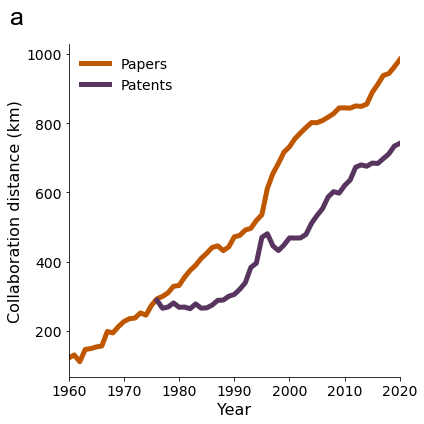

In [30]:
fig,ax=plt.subplots(1, 1, figsize=[6, 6])
## paper
ys = [y for y in range(1900,2021) if y in Y_p9]
rp = [Y_p9[y] for y in ys]
ax.plot(ys,np.array(rp),c = color_2['paper'],lw = 5,label='Papers')

## patent
ys = [y for y in range(1976,2021) if y in Y_p9_]
rp = [Y_p9_[y] for y in ys]
ax.plot(ys,np.array(rp),c= color_2['patent'],lw=5,label='Patents')

ax.set_xlabel('Year',size = 16)
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.set_ylabel('Collaboration distance (km)',size = 16)
ax.legend(fontsize=14,frameon=False,loc=2)
trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax.text(.0, 1.0, 'a', transform=ax.transAxes + trans,
            fontsize=25, va='bottom', fontfamily='arial')


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlim([1960,2020])

plt.tight_layout()
plt.show()

## Figure 2b

In [31]:
Y_p10 = defaultdict(lambda :defaultdict(list))
for p in p_f:
    if p in Dis_mean:
        Y_p10[FM[p_f[p]]][p_y[p]].append(Dis_mean[p])
Y_p11 = {}
for f in Y_p10:
    a = {y:np.mean(Y_p10[f][y]) for y in Y_p10[f]} # (paper)field-year: average collaboration distance 
    Y_p11[f] = a

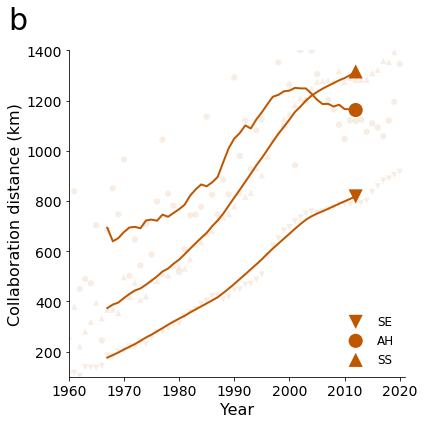

In [32]:
fig,ax=plt.subplots(figsize=[6, 6])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

markers_pa = ["v","o","^"]
n = 0
for f in ['SE','AH','SS']:
    ys = [y for y in range(1900,2021) if y in Y_p11[f]]
    rp = [Y_p11[f][y] for y in ys]
    ax.scatter(ys,rp,fc = color_2['paper'],edgecolors='none',alpha=0.1,s=40,marker=markers_pa[n])
    ys = list(map(int,list(np.convolve(ys, np.ones(16)/16, mode='valid') )))
    rp = np.convolve(rp, np.ones(16)/16, mode='valid')
    ax.plot(ys,np.array(rp),c = color_2['paper'],lw = 2)
    ax.scatter(ys[-1],np.array(rp)[-1],fc = color_2['paper'],edgecolors='none',marker=markers_pa[n],\
                s=200,label = f)
    n +=1

ax.set_xlabel('Year',size = 16)

ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.set_ylabel('Collaboration distance (km)',size=16)
trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax.text(.0, 1.0, 'b', transform=ax.transAxes + trans,
            fontsize=30, va='bottom')
ax.set_xlim([1960,2021])
ax.set_ylim([100,1400])
ax.legend(frameon=False,fontsize=12,loc=4)

plt.tight_layout()
plt.show()

## Figure 2c

In [33]:
Y_p10_ = defaultdict(lambda :defaultdict(list))
for p in p_f_pt :
    if p in Dis_mean_:
        Y_p10_[p_f_pt[p]][p_y3_[p]].append(Dis_mean_[p])

Y_p11_ = {}
for f in Y_p10_:
    a = {y:np.mean(Y_p10_[f][y]) for y in Y_p10_[f]} # (patent)field-year: average collaboration distance 
    Y_p11_[f] = a

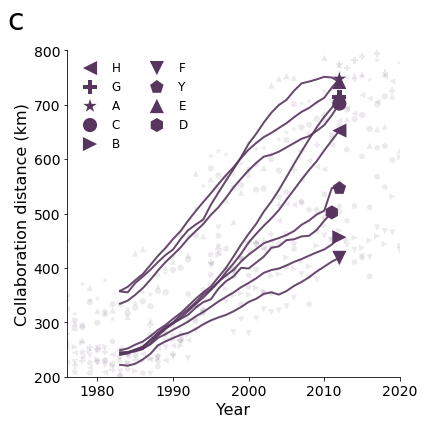

In [34]:
fig,ax2=plt.subplots(figsize=[6, 6])

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

markers_pt = ["<","P","*","o",">","v","p","^","h"]

patent_fs = ['H', 'G', 'A', 'C', 'B', 'F', 'Y', 'E', 'D']
n = 0
for f in patent_fs:
    ys = [y for y in range(1976,2021) if y in Y_p11_[f]]
    rp = [Y_p11_[f][y] for y in ys]
    ax2.scatter(ys,rp,fc = color_2['patent'],edgecolors='none',alpha=0.1,marker=markers_pt[n],s=40)
    ys = list(map(int,list(np.convolve(ys, np.ones(16)/16, mode='valid'))))
    rp = np.convolve(rp, np.ones(16)/16, mode='valid')
    ax2.plot(ys,np.array(rp),c = color_2['patent'],alpha=0.9,lw=2)
    ax2.scatter(ys[-1],np.array(rp)[-1],fc = color_2['patent'],edgecolors='none',marker=markers_pt[n],\
                s=200,label = f)
    n += 1
    
ax2.set_xlim([1976,2020])
ax2.set_ylim([200,800])
ax2.tick_params(axis='x',labelsize=14)
ax2.tick_params(axis='y',labelsize=14)
ax2.set_xlabel('Year',size = 16)
ax2.set_ylabel('Collaboration distance (km)',size = 16)

trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax2.text(.0, 1.0, 'c', transform=ax2.transAxes + trans,
            fontsize=30, va='bottom')
ax2.legend(ncol=2,frameon=False,fontsize=12,loc=2)

plt.tight_layout()
plt.show()

## Figure 3a

In [35]:
## D-score vs. collaboration distance
# bin size = 200 km
Dbins = defaultdict(list)
for p in p_d:
    if Dis_mean[p] <= 0:
        d = 0
    if Dis_mean[p] > 0 and Dis_mean[p]<=600:
        d = int(Dis_mean[p]/200+1)*200
    if Dis_mean[p]>600:
        d = 10000
    Dbins[d].append(p_d[p])
        
Dbins_ = defaultdict(list)
for p in p_d_pt2:
    if Dis_mean_[p] <= 0:
        d = 0
    if Dis_mean_[p] > 0 and Dis_mean_[p]<=600:
        d = int(Dis_mean_[p]/200+1)*200
    if Dis_mean_[p]>600:
        d = 10000
    Dbins_[d].append(p_d_pt2[p])

In [36]:
blp = np.sum([int(p_d[p]>0) for p in p_d])/len(p_d)
blpt = np.sum([int(p_d_pt2[p]>0) for p in p_d_pt2])/len(p_d_pt2)

In [37]:
## threshold of being disruptive : D-score > 0
thdpa = 0
thdpt = 0

x0 = [i for i in sorted(list(Dbins.keys()))]
y0 = [len(np.array(Dbins[i])[np.array(Dbins[i])>thdpa])/len(Dbins[i]) for i in x0 if len(Dbins[i])>0]
y0ci = [bootstrapped(list(map(lambda x:int(x>0), Dbins[i])),100) for i in x0 if len(Dbins[i])>0]
x1 = [i for i in sorted(list(Dbins_.keys()))]
y1 = [len(np.array(Dbins_[i])[np.array(Dbins_[i])>thdpt])/len(Dbins_[i]) for i in x1 if len(Dbins_[i])>0]
y1ci = [bootstrapped(list(map(lambda x:int(x>0), Dbins_[i])),100) for i in x1 if len(Dbins_[i])>0]

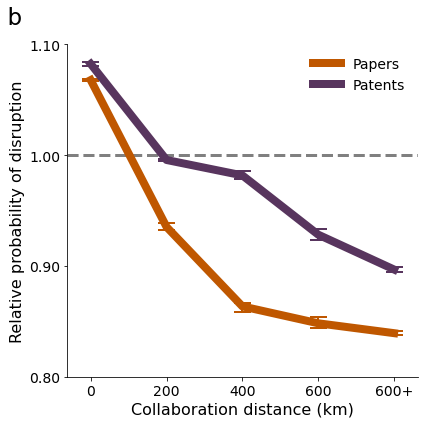

In [38]:
fig,ax2=plt.subplots(1, 1, figsize=[6, 6])

## Main figure
ax2.plot(list(range(len(x0))),np.array(y0)/blp,'-',c = color_2['paper'],lw = 8,label='Papers',zorder=100)
ax2.plot(list(range(len(x1))),np.array(y1)/blpt,'-',c = color_2['patent'],lw = 8,label='Patents',zorder=100)

for i in range(len(x0)):
    y0ci_ = np.array(y0ci)/blp
    ax2.plot([i,i],[y0ci_[i][0],y0ci_[i][1]],lw=2,color=color_2['paper'],zorder=10)
    ax2.plot([i-0.1,i+0.1],[y0ci_[i][0],y0ci_[i][0]],lw=2,color=color_2['paper'],zorder=10)
    ax2.plot([i-0.1,i+0.1],[y0ci_[i][1],y0ci_[i][1]],lw=2,color=color_2['paper'],zorder=10)

for i in range(len(x1)):
    y1ci_ = np.array(y1ci)/blpt
    ax2.plot([i,i],[y1ci_[i][0],y1ci_[i][1]],lw=2,color=color_2['patent'],zorder=10)
    ax2.plot([i-0.1,i+0.1],[y1ci_[i][0],y1ci_[i][0]],lw=2,color=color_2['patent'],zorder=10)
    ax2.plot([i-0.1,i+0.1],[y1ci_[i][1],y1ci_[i][1]],lw=2,color=color_2['patent'],zorder=10)
ax2.axhline(1,ls='--',color='grey',lw=3)
ax2.tick_params(axis='x',labelsize=14)
ax2.tick_params(axis='y',labelsize=14)
ax2.set_yticks([0.8,0.9,1,1.1])
ax2.set_yticklabels(tuple(['0.80','0.90','1.00','1.10']))
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(tuple(['0','200','400','600','600+']))
ax2.set_xlabel('Collaboration distance (km)',size = 16)
ax2.set_ylabel('Relative probability of disruption',size = 16)
ax2.legend(fontsize=14,frameon=False,loc=1)
trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax2.text(.0, 1.0, 'b', transform=ax2.transAxes + trans,
            fontsize=25, va='bottom', fontfamily='arial')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

plt.tight_layout()
plt.show()

## Figure 3b

In [39]:
TD = defaultdict(list)
for p in TZD:
    if Dis_mean[p] <=0:
        d = 0
    else:
        if TZD[p] == 0:
            d = 1
        else:
            d = 2
    TD[d].append(p_d[p])

In [40]:
tdci = [bootstrapped(list(map(lambda x:int(x>0), TD[i]))) for i in sorted(TD.keys())]

In [41]:
for d in sorted(TD.keys()):
    print(d,len(np.array(TD[d])[np.array(TD[d])>0])/len(TD[d]),\
          len(np.array(TD[d])[np.array(TD[d])>0])/len(TD[d])/blp)

0 0.28060277051574956 1.067808484735967
1 0.24236016471036473 0.9222797043809247
2 0.21562754060450579 0.8205511192104114


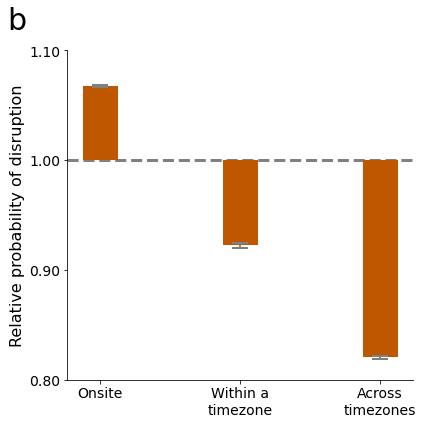

In [42]:
fig,ax=plt.subplots(figsize=[6, 6])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

bar_gap_wid = 0.6
ax.bar([0,bar_gap_wid,2*bar_gap_wid],[1.067808484735967-1, 0.9222797043809247-1, 0.8205511192104114-1],\
       width=0.15,color=color_2['paper'],zorder=100)
for i in range(3):
    y0ci_ = np.array(tdci)/blp-1
    ax.plot([i*bar_gap_wid,i*bar_gap_wid],[y0ci_[i][0],y0ci_[i][1]],color='grey',zorder=200,lw=2)
    ax.plot([i*bar_gap_wid-0.03,i*bar_gap_wid+0.03],[y0ci_[i][0],y0ci_[i][0]],color='grey',zorder=200,lw=2)
    ax.plot([i*bar_gap_wid-0.03,i*bar_gap_wid+0.03],[y0ci_[i][1],y0ci_[i][1]],color='grey',zorder=200,lw=2)


ax.set_xticks([0,bar_gap_wid,2*bar_gap_wid])
ax.set_xticklabels(tuple(['Onsite','Within a'+'\n' +'timezone','Across'+'\n' +'timezones']))
ax.set_yticks([0.8-1,0.9-1,0,1.1-1])
ax.set_yticklabels(tuple(['0.80','0.90','1.00','1.10']))
ax.axhline(0,ls='--',color='grey',lw=3)
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)

ax.set_ylabel('Relative probability of disruption',size=16)

trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax.text(.0, 1.0, 'b', transform=ax.transAxes + trans,
            fontsize=30, va='bottom')

plt.tight_layout()
plt.show()

## Figure 3c

In [43]:
TD_pt = defaultdict(list)
for p in TZD_pt:
    if Dis_mean_[p] <=0:
        d = 0
    else:
        if TZD_pt[p] == 0:
            d = 1
        else:
            d = 2
    TD_pt[d].append(p_d_pt2[p])

In [44]:
tdci_ = [bootstrapped(list(map(lambda x:int(x>0), TD_pt[i]))) for i in sorted(TD_pt.keys())]

In [45]:
for d in sorted(TD_pt.keys()):
    print(d,len(np.array(TD_pt[d])[np.array(TD_pt[d])>0])/len(TD_pt[d]),\
          len(np.array(TD_pt[d])[np.array(TD_pt[d])>0])/len(TD_pt[d])/blpt)

0 0.6683476903145967 1.0823996774218063
1 0.6132580945804704 0.9931812039894403
2 0.5459274115287572 0.8841380956314843


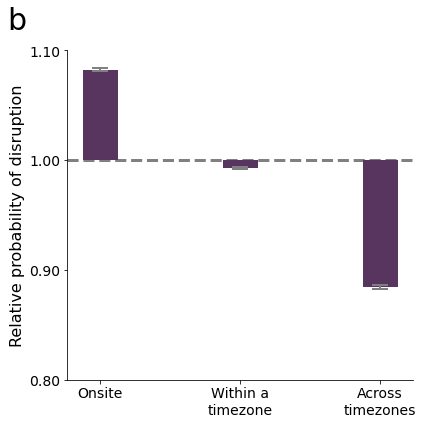

In [46]:
fig,ax=plt.subplots(figsize=[6, 6])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

bar_gap_wid = 0.6
ax.bar([0,bar_gap_wid,2*bar_gap_wid],[1.0823996774218063-1, 0.9931812039894403-1, 0.8841380956314843-1],\
        width=0.15,color=color_2['patent'],zorder=100)
for i in range(3):
    y1ci_ = np.array(tdci_)/blpt-1
    ax.plot([i*bar_gap_wid,i*bar_gap_wid],[y1ci_[i][0],y1ci_[i][1]],color='grey',zorder=200,lw=2)
    ax.plot([i*bar_gap_wid-0.03,i*bar_gap_wid+0.03],[y1ci_[i][0],y1ci_[i][0]],color='grey',zorder=200,lw=2)
    ax.plot([i*bar_gap_wid-0.03,i*bar_gap_wid+0.03],[y1ci_[i][1],y1ci_[i][1]],color='grey',zorder=200,lw=2)


ax.set_xticks([0,bar_gap_wid,2*bar_gap_wid])

ax.set_xticklabels(tuple(['Onsite','Within a'+'\n' +'timezone','Across'+'\n' +'timezones']))
ax.set_yticks([0.8-1,0.9-1,0,1.1-1])
ax.set_yticklabels(tuple(['0.80','0.90','1.00','1.10']))
ax.axhline(0,ls='--',color='grey',lw=3)
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)

ax.set_ylabel('Relative probability of disruption',size=16)

trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax.text(.0, 1.0, 'b', transform=ax.transAxes + trans,
            fontsize=30, va='bottom')

plt.tight_layout()
plt.show()

## Figure 4a

In [47]:
AP = defaultdict(lambda:defaultdict(lambda :defaultdict(list)))
for p in PA:
        d_ = PA[p]['Remoteness']
        if d_ > 0:
            d = 1
        else:
            d = 0
        as_ = set(PA[p]['Authors'])
        for w in ['conceived','wrote','performed','analyzed']:
            if w in PA[p]['Contributions']:
                for a in as_:
                    if a in PA[p]['Contributions'][w]:
                        AP[a][d][w].append(1)
                    else:
                        AP[a][d][w].append(0)

            else:
                for a in as_:
                    AP[a][d][w].append(0)
                    
WLR = defaultdict(lambda:defaultdict(list))
n = 0
for a in AP:
    if len(AP[a]) == 2:
        for w in ['conceived','wrote','performed','analyzed']:
#             if np.sum(AP[a][0][w])+np.sum(AP[a][1][w])>0:
            WLR[w][0].append(np.mean(AP[a][0][w]))
            WLR[w][1].append(np.mean(AP[a][1][w]))
        n += 1
# n = 21373

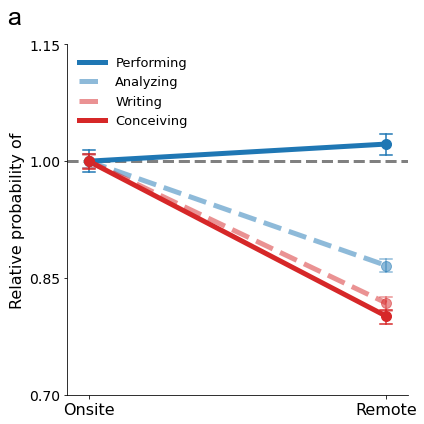

In [48]:
fig,ax3=plt.subplots(1, 1, figsize=[6, 6])

cmap = cm.get_cmap('tab10',10)

colors = {
    'conceived':('#d62728',1,'-'),
    'wrote':('#d62728',0.5,'--'),
    'performed':('#1f77b4',1,'-'),
    'analyzed':('#1f77b4',0.5,'--')
    
}
L = {
    'performed':'Performing',
    'analyzed':'Analyzing',
    'wrote':'Writing',
    'conceived':'Conceiving'
}
## Main figure
for w in [ 'performed', 'analyzed', 'wrote','conceived']:
    menMeans = np.array([np.mean(WLR[w][0]),np.mean(WLR[w][1])])
    ax3.plot(range(2),menMeans/menMeans[0],ls = colors[w][2],color=colors[w][0],lw = 5,alpha = colors[w][1],label=L[w],ms=12,zorder=50)
    ax3.scatter(range(2),menMeans/menMeans[0],color=colors[w][0],alpha = colors[w][1],s=100,zorder=100)
    y0ci_ = np.array(bootstrapped(WLR[w][0],100))/np.mean(WLR[w][0])
    ax3.plot([0,0],[y0ci_[0],y0ci_[1]],color=colors[w][0],alpha = colors[w][1],zorder=10)
    ax3.plot([0-0.02,0+0.02],[y0ci_[0],y0ci_[0]],color=colors[w][0],alpha = colors[w][1],zorder=10)
    ax3.plot([0-0.02,0+0.02],[y0ci_[1],y0ci_[1]],color=colors[w][0],alpha = colors[w][1],zorder=10)
    
    y0ci_ = np.array(bootstrapped(WLR[w][1],100))/np.mean(WLR[w][0])
    ax3.plot([1,1],[y0ci_[0],y0ci_[1]],color=colors[w][0],alpha = colors[w][1],zorder=10)
    ax3.plot([1-0.02,1+0.02],[y0ci_[0],y0ci_[0]],color=colors[w][0],alpha = colors[w][1],zorder=10)
    ax3.plot([1-0.02,1+0.02],[y0ci_[1],y0ci_[1]],color=colors[w][0],alpha = colors[w][1],zorder=10)
    n += 1
ax3.axhline(1,ls='--',color='grey',lw=3)

ax3.tick_params(axis='x',labelsize=16)
ax3.tick_params(axis='y',labelsize=14)
ax3.set_ylim(0.70,1.15)
ax3.set_yticks([0.70,0.85,1.0,1.15])
ax3.set_yticklabels(['0.70','0.85','1.00',1.15])
ax3.set_ylabel('Relative probability of',size=16)
ax3.set_xticks([0,1])
ax3.set_xticklabels(['Onsite','Remote'])


trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax3.text(.0, 1.0, 'a', transform=ax3.transAxes + trans,
            fontsize=25, va='bottom', fontfamily='arial')
ax3.legend(fontsize = 13,frameon = False,loc=2)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)

plt.tight_layout()
plt.show()

## Figure 4b

In [49]:
## bin size of citation-difference scale  = 0.5
delta = 0.5
x1 = defaultdict(list)
for i in GO_SC_R:
    x1[int(i/delta)*delta] += GO_SC_R[i]
x2 = defaultdict(list)
for i in GR_SC_R:
    x2[int(i/delta)*delta] += GR_SC_R[i]
    
x_1 = [i for i in sorted(x1) if i <=4]
y_1 = [np.mean(x1[i]) for i in x_1]

x_2 = [i for i in sorted(x2) if i <=4]
y_2 = [np.mean(x2[i]) for i in x_2]

In [50]:
### regression between citation impact difference and probability of co-conceiving
import statsmodels.api as sm
df = pd.DataFrame()
y_1_all = []
x_1_all = []
for i in sorted(x1):
    if i <=4:
        x_1_all += [i]*len(x1[i])
        y_1_all += x1[i]
    
y_2_all = []
x_2_all = []
for i in sorted(x2):
    if i <=4:
        x_2_all += [i]*len(x2[i])
        y_2_all += x2[i]
    
df['y'] = y_1_all
df['x'] = x_1_all
y = df['y'] 
x = df['x']
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

df = pd.DataFrame()
df['y'] = y_2_all
df['x'] = x_2_all
y = df['y'] 
x = df['x']
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02940
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.864
Time:                        10:29:01   Log-Likelihood:            -1.0410e+05
No. Observations:              155842   AIC:                         2.082e+05
Df Residuals:                  155840   BIC:                         2.082e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3345      0.002    174.533      0.0

In [51]:
## Onsite teams: OLS regression indicated by the green line, coefficient = 0.0002, p-value = 0.864, n = 155,842
## Remote teams: OLS regression indicated by the orange line, coefficient = -0.0224, p-value < 0.001, n = 296,861

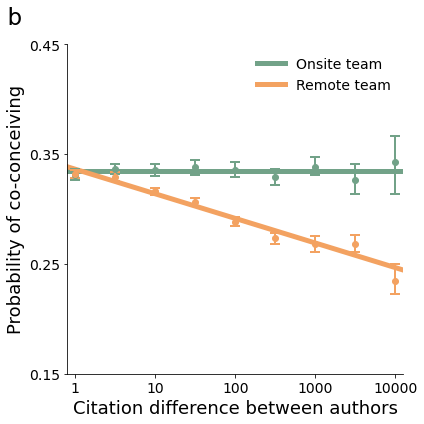

In [52]:
fig,ax2=plt.subplots(1, 1, figsize=[6, 6])

## Main figure
ax2.scatter(x_1,y_1,color='#72A288',zorder=100)
for i in range(len(x_1)):
    y0ci_ = bootstrapped(x1[x_1[i]],100)
    ax2.plot([i*0.5,i*0.5],[y0ci_[0],y0ci_[1]],lw=2,color='#72A288',zorder=10)
    ax2.plot([i*0.5-0.05,i*0.5+0.05],[y0ci_[0],y0ci_[0]],lw=2,color='#72A288',zorder=10)
    ax2.plot([i*0.5-0.05,i*0.5+0.05],[y0ci_[1],y0ci_[1]],lw=2,color='#72A288',zorder=10)
    
ax2.scatter(x_2,y_2,color='#F3A261',zorder=100)
for i in range(len(x_2)):
    y0ci_ = bootstrapped(x2[x_2[i]],100)
    ax2.plot([i*0.5,i*0.5],[y0ci_[0],y0ci_[1]],lw=2,color='#F3A261',zorder=10)
    ax2.plot([i*0.5-0.05,i*0.5+0.05],[y0ci_[0],y0ci_[0]],lw=2,color='#F3A261',zorder=10)
    ax2.plot([i*0.5-0.05,i*0.5+0.05],[y0ci_[1],y0ci_[1]],lw=2,color='#F3A261',zorder=10)

ax2.axhline(np.mean(y_1),lw=5,color ='#72A288',zorder=1,label='Onsite team')
x2_ = np.linspace(-0.1, 4.1, 100)
y2_ = -0.0224*x2_+0.3363
ax2.plot(x2_,y2_,color='#F3A261',label='Remote team',lw=5,zorder=1)


ax2.tick_params(axis='x',labelsize=14)
ax2.tick_params(axis='y',labelsize=14)
ax2.set_yticks([0.15,0.25,0.35,0.45]) 
ax2.set_xticks([0,1,2,3,4]) 
ax2.set_xticklabels(tuple(['1','10','100','1000','10000']))
ax2.set_xlim(-0.1,4.1)
ax2.set_ylim(0.15,0.45)
trans = mtransforms.ScaledTranslation(-60/72, 15/72, fig.dpi_scale_trans)
ax2.text(.0, 1.0, 'b', transform=ax2.transAxes + trans,
            fontsize=25, va='bottom', fontfamily='arial')

ax2.set_xlabel('Citation difference between authors',size=18)
ax2.set_ylabel('Probability of co-conceiving',size=18)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.legend(fontsize=14,frameon=False,loc=1)

plt.tight_layout()
plt.show()